In [1]:
import xlrd
import xlwt
data = xlrd.open_workbook("/Applications/anaconda3/SFE_Dataset.xlsx")
data.sheet_names()
table = data.sheet_by_name('SFE Dataset')
rownum = table.nrows
colnum = table.ncols
newdata = xlwt.Workbook()
#Preprocess0: remove the middle values
new = newdata.add_sheet('preprocess0')
l = 0
for i in range(1,rownum):
    temprow = table.row_values(i)
    num = temprow[-1]
    if num >= 45 or num <= 35:
        for j in range(colnum):
            new.write(l,j,temprow[j])
        l += 1
#Preprocess1: discard all predictors that do not have at least 60% nonzero values
newdata = xlrd.open_workbook('newdata.xls')
new = newdata.add_sheet('preprocess0')
colnum = new.ncols
rownum = new.nrows
l = 0
for i in range(colnum):
    tempcol = new.col_values(i)
    num = tempcol.count(0)
    if (num/(rownum-1)<=0.4):
        for j in range(rownum):
            new.write(j,l,tempcol[j])
        l += 1
#Preprocess2: remove the rows (samples) that contain any zero values
newdata1 = xlrd.open_workbook('newdata.xls')
new1 = newdata1.sheet_by_name('preprocess1')
newcolnum = new1.ncols
newrownum = new1.nrows
new = newdata.add_sheet('preprocess2')
l = 0
for i in range(newrownum):
    temprow = new1.row_values(i)
    num = temprow.count(0)
    if num == 0:
        for j in range(newcolnum):
            new.write(l,j,temprow[j])
        l += 1
#Preprocess3: remove the samples whose SFE locates between 35-45.
newdata2 = xlrd.open_workbook('newdata.xls')
new2 = newdata1.sheet_by_name('preprocess2')
newcolnum = new2.ncols
newrownum = new2.nrows
new = newdata.add_sheet('preprocess3')
l = 0
for i in range(1,newrownum):
    temprow = new2.row_values(i)
    num = temprow[-1]
    if num >= 45 or num <= 35:
        for j in range(newcolnum):
            new.write(l,j,temprow[j])
        l += 1

newdata.save('newdata.xls')
# After preprocessing,number of total samples is 126 and number of 
# predictors is 7.

In [2]:
#group data into training data and sample data
import random
import xlrd
import xlwt

#import data after preprocess
data = xlrd.open_workbook('newdata.xls')
new = data.sheet_by_name('preprocess3')
colnum = new.ncols
rownum = new.nrows

# temp is the list of samples' sfe values.
temp = new.col_values(-1)

#Keep selecting training samples unless it meets the requirment.
while 1:
    sfe = []
    l = []
    l = [random.randint(0,126) for _ in range(25)]
    print(l)
    for i in l:
        if temp[i] <= 35:
            sfe.append(0)
        else:
            sfe.append(1)
    if sfe.count(0)/25 <=0.55 and sfe.count(1)/25 <= 0.55:
        break
        
#Devide training samples into two groups. Group0 and group1.
L0,L1 = [],[]
for i in range(25):
    temprow = new.row_values(l[i])
    if sfe[i] == 0:
        L0.append(temprow)
    elif sfe[i] == 1:
        L1.append(temprow)
newdata.save('newdata.xls')       

[4, 20, 25, 46, 24, 29, 80, 124, 59, 125, 59, 42, 51, 16, 115, 67, 119, 7, 69, 79, 69, 25, 42, 116, 53]
[115, 100, 91, 69, 43, 92, 48, 100, 60, 29, 72, 123, 32, 20, 103, 25, 38, 75, 56, 2, 27, 109, 85, 124, 37]


In [132]:
#write Statistic T function
from numpy import*
import numpy as np
import math
def T(xa,xb):
    na = len(xa)
    nb = len(xb)
    ua = np.mean(xa)
    ub = np.mean(xb)
    va = np.var(xa)
    vb = np.var(xb)
    t = (ua-ub)/math.sqrt(va/na+vb/nb)
    return abs(t)
#Caculate T-values of 7 predictors
pdset0 = mat(L0).T
pdset1 = mat(L1).T
tvalue = []
for i in range(8):
    tvalue.append(T(pdset0[i],pdset1[i]))


In [133]:
print(tvalue)

[0.4508978890950614, 0.16832985484594901, 1.5966637670020243, 2.375185908674172, 0.1325590621931369, 0.63786335973775599, 0.21773859919166474, 5.1959294227052046]


In [136]:
#Caculate p-value
from scipy import stats
pvalue = []
for t in tvalue:
    p = 1 - stats.t.cdf(t,50)
    pvalue.append(p)
print(pvalue)

[0.3270062819511077, 0.43350143136668429, 0.058321189420929676, 0.010708013186131571, 0.44753707362691419, 0.26323660142269389, 0.41425947754395243, 1.8828312701169025e-06]


In [216]:
import xlrd
import xlwt
newdata3 = xlrd.open_workbook('newdata.xls')
new3 = newdata1.sheet_by_name('preprocess3')
newcolnum = new3.ncols
newrownum = new3.nrows
samples = xlwt.Workbook()
#Creat a new sheet for training data.
new = samples.add_sheet('training data')
a = 0
for i in range(25):
    temprow = new3.row_values(l[i])
    for j in range(newcolnum):
        new.write(a,j,temprow[j])
    a += 1
#Creat a new sheet for testing data.
new = samples.add_sheet('testing data')
ltest = []
for i in range(126):
    if i not in l:
        ltest.append(i)
b = 0
for i in range(len(ltest)):
    temprow = new3.row_values(ltest[i])
    for j in range(newcolnum):
        new.write(b,j,temprow[j])
    b += 1
#Import data from testing data.
Ltest0,Ltest1,Ltest03,Ltest13,Ltest04,Ltest14,Ltest05,Ltest15 = [],[],[],[],[],[],[],[]
newdata = xlrd.open_workbook('samples.xls')
test = newdata.sheet_by_name('testing data')
testcolnum = test.ncols
testrownum = test.nrows
for i in range(testrownum):
    temprow = test.row_values(i)
    if temprow[-1] <= 35:
        Ltest0.append([temprow[2],temprow[3]])
        Ltest03.append([temprow[2],temprow[3],temprow[5]])
        Ltest04.append([temprow[2],temprow[3],temprow[5],temprow[0]])
        Ltest05.append([temprow[2],temprow[3],temprow[5],temprow[0],temprow[6]])
    else:
        Ltest1.append([temprow[2],temprow[3]])
        Ltest13.append([temprow[2],temprow[3],temprow[5]])
        Ltest14.append([temprow[2],temprow[3],temprow[5],temprow[0]])
        Ltest15.append([temprow[2],temprow[3],temprow[5],temprow[0],temprow[6]])
samples.save('samples.xls')

In [217]:
Ltest15

[[15.6, 64.317, 0.02, 0.004, 17.5],
 [14.0, 66.409, 0.01, 0.02, 17.1],
 [15.6, 63.866, 0.01, 0.005, 17.7],
 [15.32, 64.4774, 0.01, 0.0006, 17.7],
 [15.4, 69.1557, 0.02, 0.003, 13.09],
 [15.65, 64.9178, 0.03, 0.074, 17.02],
 [15.56, 65.0561, 0.03, 0.002, 16.95],
 [15.51, 66.9658, 1.82, 0.003, 13.35],
 [19.85, 52.98, 1.08, 0.05, 24.11],
 [7.58, 64.718, 0.17, 0.033, 18.8],
 [16.3, 54.698, 0.45, 0.03, 18.48],
 [16.3, 54.698, 0.45, 0.03, 18.48],
 [16.3, 54.698, 0.45, 0.03, 18.48],
 [16.3, 54.698, 0.45, 0.03, 18.48],
 [16.3, 54.698, 0.45, 0.03, 18.48],
 [16.13, 54.8, 0.45, 0.07, 18.48],
 [16.13, 54.71, 0.45, 0.07, 18.48],
 [16.13, 54.57, 0.45, 0.07, 18.48],
 [16.23, 63.27, 0.1, 0.07, 18.63],
 [16.13, 55.008, 0.45, 0.07, 18.48],
 [16.13, 54.908, 0.45, 0.07, 18.48],
 [16.13, 54.818, 0.45, 0.07, 18.48],
 [16.13, 54.678, 0.45, 0.07, 18.48],
 [7.11, 62.329, 0.43, 0.027, 21.0],
 [15.8, 68.23, 0.04, 0.017, 15.9],
 [24.7, 59.86, 0.015, 0.011, 15.4],
 [15.6, 64.317, 0.02, 0.004, 17.5],
 [15.6, 64.188

In [154]:
#Import training data.
x0 = [];x1 = []
for i in range(len(L0)):
    x0.append([L0[i][2],L0[i][3]])
for i in range(len(L1)):
    x1.append([L1[i][2],L1[i][3]])
num0 = len(x0)
num1 = len(x1)
x0 = array(x0).T
x1 = array(x1).T


12

In [188]:
x03 = [];x13 = [];x04=[];x14=[];x05=[];x15=[]
for i in range(len(L0)):
    x03.append([L0[i][2],L0[i][3],L0[i][5]])
    x04.append([L0[i][2],L0[i][3],L0[i][5],L0[i][0]])
    x05.append([L0[i][2],L0[i][3],L0[i][5],L0[i][0],L0[i][6]])
for i in range(len(L1)):
    x13.append([L1[i][2],L1[i][3],L1[i][5]])
    x14.append([L1[i][2],L1[i][3],L1[i][5],L1[i][0]])
    x15.append([L1[i][2],L1[i][3],L1[i][5],L1[i][0],L1[i][6]])
x03 = array(x03).T
x13 = array(x13).T
x04 = array(x04).T
x14 = array(x14).T
x05 = array(x05).T
x15 = array(x15).T


In [190]:
x13

array([[  1.53200000e+01,   1.57500000e+01,   1.40000000e+01,
          1.24800000e+01,   1.56000000e+01,   1.39300000e+01,
          1.61300000e+01,   1.59700000e+01,   1.57200000e+01,
          1.57200000e+01,   1.57200000e+01,   1.57500000e+01],
       [  6.44774000e+01,   6.49895000e+01,   6.64090000e+01,
          5.88960000e+01,   6.41880000e+01,   6.59640000e+01,
          5.49000000e+01,   6.27700000e+01,   6.08673000e+01,
          6.08673000e+01,   6.08673000e+01,   6.49895000e+01],
       [  1.00000000e-02,   3.00000000e-03,   1.00000000e-02,
          4.90000000e-01,   3.00000000e-02,   2.00000000e-02,
          4.50000000e-01,   1.00000000e-02,   3.00000000e-02,
          3.00000000e-02,   3.00000000e-02,   3.00000000e-03]])

In [206]:
#Parameters of LDA function
from numpy import*
def lda(x0,x1):
    u0lda = mat([mean(x0[i]) for i in range(len(x0))])
    u1lda = mat([mean(x1[i]) for i in range(len(x1))])
    sigma0 = cov(x0)*(13/25)
    sigma1 = cov(x1)*(12/25)
    sigma = mat(sigma0+sigma1)
    a = sigma.I *(u1lda-u0lda).T
    b = -0.5*(u1lda-u0lda)*sigma.I*(u1lda+u0lda).T
    return a,b

In [224]:
mat(Ltest0[0])*a

matrix([[  270.   ,  1722.475]])

In [250]:
#Errorestimat Function
from numpy import*
def errorestimate(x0,x1,Ltest0,Ltest1):
    a,b = lda(x0,x1)
    ernum0 = 0
    ernum1 = 0
    for i in Ltest0:
        num = array(i)*a + b
        if num > 0:
            ernum0 += 1
    for j in Ltest1:
        num = array(j)*a + b
        if num < 0:
            ernum1 += 1     
    return (ernum0+ernum1)/101

In [251]:
errorestimate(x0,x1,Ltest0,Ltest1)

0.12871287128712872

In [252]:
errorestimate(x03,x13,Ltest03,Ltest13)

0.10891089108910891

In [253]:
errorestimate(x04,x14,Ltest04,Ltest14)

0.1188118811881188

In [254]:
errorestimate(x05,x15,Ltest05,Ltest15)

0.1188118811881188

In [234]:
#Caculate the parameters of LDA classifier
from numpy import*
from numpy import*
u0lda = mat([mean(x0[0]),mean(x0[1])])
u1lda = mat([mean(x1[0]),mean(x1[1])])
sigma0 = cov(x0)*(num0/(num0+num1))
sigma1 = cov(x1)*(num1/(num0+num1))
sigma = mat(sigma0 + sigma1)
a = sigma.I * (u1lda - u0lda).T
b = -0.5*(u1lda-u0lda)*sigma.I*(u1lda+u0lda).T
print (a)
print (b)

[[ 0.58335544]
 [-1.13780423]]
[[ 68.76741451]]


In [237]:
array(Ltest0[0])*a

matrix([[-72.09333472]])

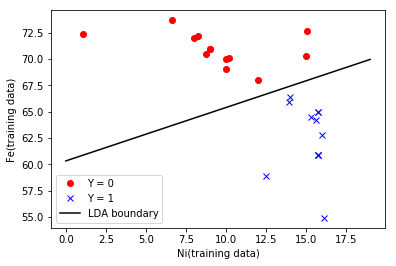

In [204]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as show
#Scatter Plot
plt.figure(1)
plt.plot(x0[0],x0[1],"ro",label = "Y = 0")
plt.plot(x1[0],x1[1],"bx",label = "Y = 1")
#Plot Optimal Classifier
x = range(0,20)
y = [60.32 + 0.508*i for i in x]
plt.plot(x,y,color = "black",label = "LDA boundary")
plt.xlabel("Ni(training data)")
plt.ylabel("Fe(training data)")
plt.legend()
plt.show()

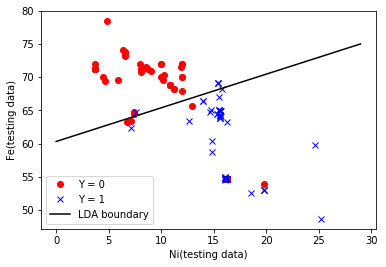

In [174]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as show
x0test = array(Ltest0).T
x1test = array(Ltest1).T
#Scatter Plot
plt.figure(1)
plt.plot(x0test[0],x0test[1],"ro",label = "Y = 0")
plt.plot(x1test[0],x1test[1],"bx",label = "Y = 1")
#Plot Optimal Classifier
x = range(0,30)
y = [60.32 + 0.508*i for i in x]
plt.plot(x,y,color = "black",label = "LDA boundary")
plt.xlabel("Ni(testing data)")
plt.ylabel("Fe(testing data)")
plt.legend()
plt.show()

In [179]:
x13

[[15.32, 64.4774, 0.01],
 [15.75, 64.9895, 0.003],
 [14.0, 66.409, 0.01],
 [12.48, 58.896, 0.49],
 [15.6, 64.188, 0.03],
 [13.93, 65.964, 0.02],
 [16.13, 54.9, 0.45],
 [15.97, 62.77, 0.01],
 [15.72, 60.8673, 0.03],
 [15.72, 60.8673, 0.03],
 [15.72, 60.8673, 0.03],
 [15.75, 64.9895, 0.003]]

In [180]:
x15

[[15.32, 64.4774, 0.01, 0.0006, 17.7],
 [15.75, 64.9895, 0.003, 0.002, 16.95],
 [14.0, 66.409, 0.01, 0.02, 17.1],
 [12.48, 58.896, 0.49, 0.021, 24.82],
 [15.6, 64.188, 0.03, 0.02, 17.6],
 [13.93, 65.964, 0.02, 0.023, 16.85],
 [16.13, 54.9, 0.45, 0.07, 18.48],
 [15.97, 62.77, 0.01, 0.03, 18.07],
 [15.72, 60.8673, 0.03, 0.002, 17.13],
 [15.72, 60.8673, 0.03, 0.002, 17.13],
 [15.72, 60.8673, 0.03, 0.002, 17.13],
 [15.75, 64.9895, 0.003, 0.002, 16.95]]